# Exploratory Analysis, Feature Engineering & Encoding of the Titanic Dataset


## Introduction

In this tutorial we will perform exploratory data analysis on a simple dataset, handle missing values and carry out some basic feature engineering. Having prepared the data, we will then build and evaluate a simple model.

First we load the libraries needed to complete the analysis and set some defaults.

In [1]:
import random
import pandas as pd
import numpy as np
import re
import matplotlib
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
sns.set_style('whitegrid')
pd.options.mode.chained_assignment = None 

Next, load the titanic.csv datafile. The code below assumes that this file is located in the same directory as the notebook

In [2]:
#titanic_data = pd.read_csv('titanic.csv') 
titanic_data = pd.read_csv('/Users/eupirate/Documents/DA_L7/L7_term2/CA1_data_exp_vis_prep/wk6_titanic.csv') 
titanic_data = titanic_data.rename(columns={'Sex': 'Gender'})

In [3]:
titanic_data 

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Now that you have loaded the data, you can examine it by using the *head()* and *tail()* methods of the dataframe. Note this is left as an exercise for you to do. A description of the dataset is as follows:

| Attribute | Description     |
| :-------- | :-------------- |
| Survived  | 0 = No, 1 = Yes |
| Pclass    | Passenger Class |
| Name | Passenger Name |
| Gender | male/female |
| Age | Age |
| Sibsp | Number of Siblings or Spouses Aboard |
| Parch | Number of Parents/Children Aboard |
| Ticket | Ticket Number |
| Fare | Passenger Fare |
| Cabin | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |


## Handling Missing Data

We will first use a seaborn heatmap to visualise missing data.

<Axes: >

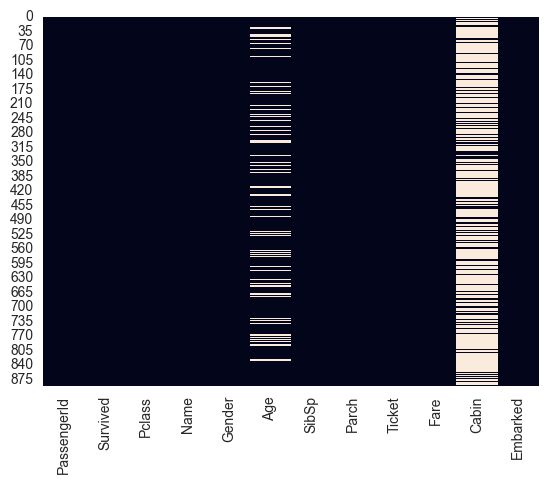

In [4]:
sns.heatmap(titanic_data.isnull(), cbar=False)

The **Cabin** variable has such a high level of missingness that it is unlikely to be of any use in a predictive model. The **Age** variable also has a relatively high level of missingness. We will return to this later. 

While a heatmap is useful, it may hide missingness in variables that have a very small number of missing data. Here we use a list comprehension to produce a count of missing data for each variable where data are missing. 

In [5]:
[(col,titanic_data[col].isnull().sum()) for col in titanic_data.columns if titanic_data[col].isnull().any()]

[('Age', 177), ('Cabin', 687), ('Embarked', 2)]

As you can see, the **Embarked** variable is missing values for one observation. This is such a small number that we could easily take the easy way out and delete these observations. Alternatively, we can explore the data a little further to see if the missing port of embarkation can be reliably determined from the values in other variables. Two variables that could be of help here are the passenger class and fare. We first find out the passenger class and fare for the two passengers missing the port of embarcation:

In [6]:
titanic_data.loc[titanic_data.Embarked.isnull(),['Pclass','Fare']]

,Pclass,Fare
61,1,80.0
829,1,80.0


So both passengers with missing embarcation information are in 1st class and paid £80 for their fare. We can use a box and whisker plot to visualise the distribution (spread) of fares for each passenger class at each port of embarcation in the hopes that it reveals sufficient information to allow a reasonable choice of port of embarcation with which to replace the missing data.

<Axes: xlabel='Embarked', ylabel='Fare'>

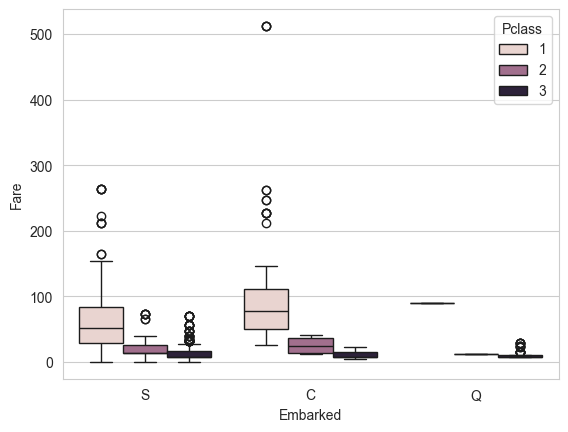

In [7]:
titanic_embarked = titanic_data[titanic_data.Embarked.notnull()]
sns.boxplot(x='Embarked', y='Fare', hue='Pclass', data=titanic_embarked)

Both passengers paid the same fare and are both in 1st class. The price they paid is almost the same as the mean price of 1st class passengers that boarded in Cherbourg. 

We can reasonably ignore Queenstown simply because there are so few passengers boarding here. 

We can also dismiss Southampton as a valid option, as the fare of 80 would very close the third quartile of the fares for that port. In other wrods, a fare of 80 would be more expensive than that paid by almost 75% of 1st class passengers that boarded here.

So we will proceed with replacing the missing data in the Embarked variable with the value 'C' for Cherbourg. 

In [8]:
titanic_data['Embarked'] = titanic_data['Embarked'].fillna('C')


Now we come to dealing with missing values in the **Age** variable. Unlike the situation with the **Embarked** variable, here we have almost 20% missing values. 

A simple and somewhat na&iuml;ve option would would be to replace missing values with the mean. However, there are other more suitable options, such as **multiple imputation**, which uses machine learning to impute the most likely values for the missing data. 

As such methods use machine learning, our data need to be prepared in just they same way as they would for an analytical machine learning model. In other words, they should be correctly **encoded**. 

We should first look at each variable to determine if it is likely to contribute to a reliable imputation. 

The variables *PassengerId*, *Name*, *Ticket Number* and *Cabin* have such a high cardinality that they are unlikely to be useful to us. We also have to drop the *Survived* variable, as it is the target of any future predictions.

We are left with the variables *Gender*, *Age*, *Number of Siblings or Spouses Aboard*, *Number of Parents/Children Aboard* and *Embarked*. 

Of these variables, only *Embarked* and *Gender* need to encoded. We will use a **one-hot encoder** because the first imputation technique we will try is k-Nearest Neighbours, a machine learning algorithm that is based on Euclidian distance.

In [9]:
titanic_one_hot = pd.get_dummies(titanic_data, columns=['Embarked','Gender'])
titanic_one_hot.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','Survived'],axis=1, inplace=True)


### Imputation using the mean (or median)



In [10]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(titanic_one_hot)
titanic_imputed_mean = imputer.transform(titanic_one_hot)
age_imputed_mean = titanic_imputed_mean[...,1]
age_imputed_mean

array([22.        , 38.        , 26.        , 35.        , 35.        ,
       29.69911765, 54.        ,  2.        , 27.        , 14.        ,
        4.        , 58.        , 20.        , 39.        , 14.        ,
       55.        ,  2.        , 29.69911765, 31.        , 29.69911765,
       35.        , 34.        , 15.        , 28.        ,  8.        ,
       38.        , 29.69911765, 19.        , 29.69911765, 29.69911765,
       40.        , 29.69911765, 29.69911765, 66.        , 28.        ,
       42.        , 29.69911765, 21.        , 18.        , 14.        ,
       40.        , 27.        , 29.69911765,  3.        , 19.        ,
       29.69911765, 29.69911765, 29.69911765, 29.69911765, 18.        ,
        7.        , 21.        , 49.        , 29.        , 65.        ,
       29.69911765, 21.        , 28.5       ,  5.        , 11.        ,
       22.        , 38.        , 45.        ,  4.        , 29.69911765,
       29.69911765, 29.        , 19.        , 17.        , 26.  

### Imputation using k-Nearest Neighbours

In [11]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(titanic_one_hot)
titanic_imputed_knn = imputer.transform(titanic_one_hot)
age_imputed_knn = titanic_imputed_knn[:,1]
age_imputed_knn

array([22.   , 38.   , 26.   , 35.   , 35.   , 47.2  , 54.   ,  2.   ,
       27.   , 14.   ,  4.   , 58.   , 20.   , 39.   , 14.   , 55.   ,
        2.   , 26.6  , 31.   , 23.   , 35.   , 34.   , 15.   , 28.   ,
        8.   , 38.   , 32.5  , 19.   , 21.7  , 24.   , 40.   , 21.584,
       21.1  , 66.   , 28.   , 42.   , 24.8  , 21.   , 18.   , 14.   ,
       40.   , 27.   , 29.4  ,  3.   , 19.   , 22.4  , 33.2  , 21.1  ,
       26.4  , 18.   ,  7.   , 21.   , 49.   , 29.   , 65.   , 49.4  ,
       21.   , 28.5  ,  5.   , 11.   , 22.   , 38.   , 45.   ,  4.   ,
       35.6  , 24.4  , 29.   , 19.   , 17.   , 26.   , 32.   , 16.   ,
       21.   , 26.   , 32.   , 25.   , 24.   , 22.4  ,  0.83 , 30.   ,
       22.   , 29.   , 21.1  , 28.   , 17.   , 33.   , 16.   , 22.4  ,
       23.   , 24.   , 29.   , 20.   , 46.   , 26.   , 59.   , 22.4  ,
       71.   , 23.   , 34.   , 34.   , 28.   , 24.   , 21.   , 33.   ,
       37.   , 28.   , 21.   , 35.   , 38.   , 31.4  , 47.   , 14.5  ,
      

In order to assess the suitability of the imputed data, it is important to determine if the imputation has fundamentally altered the distribution of the data. We can do this using a histogram or a kernel density estimate plot. 

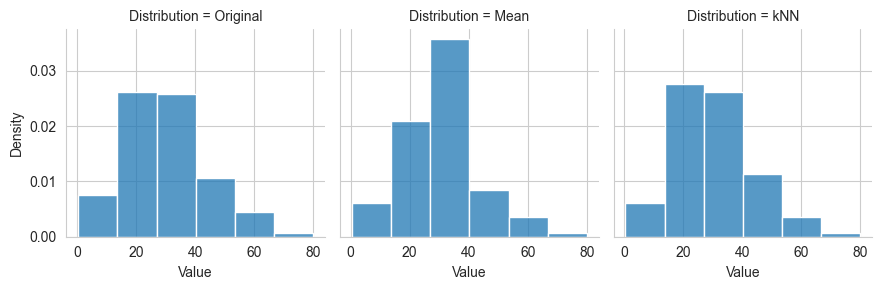

In [12]:
### preparing the histogram using the original Dataframe
values = titanic_data['Age'].tolist()
names = list(['Original'] * len(values))

### Mean imputation
values.extend(age_imputed_mean)
names.extend(list(['Mean'] * len(age_imputed_mean)))

### KNN imputation
values.extend(age_imputed_knn)
names.extend(list(['kNN'] * len(age_imputed_knn)))
dist_data = pd.DataFrame({'Distribution': names, 'Value': values})
grid = sns.FacetGrid(dist_data, col='Distribution', col_wrap=3)
grid.map(sns.histplot, 'Value', bins = 6, stat='density')

As you can see the imputation with mean the mean alters the distribution the most whereas the data imputed by kNN appear to better preserve the distribution.

In [13]:
titanic_data['Age'] = age_imputed_knn


In [14]:
## double check missing data

[(col,titanic_data[col].isnull().sum()) for col in titanic_data.columns if titanic_data[col].isnull().any()]


[('Cabin', 687)]

Imputing missing values for the **Age** variable was a little on the complicated side. What about the **Cabin** variable? Here we have just over 77% missing values. Without drawing on external data, such as the [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/cabins.html), it would be an impossible task to reliably impute the missing values. For now, we will just add this to the list of variables to be removed from the data.

## Further Exploratory Analysis

As we move through this tutorial, one of our tasks will be the examination of pairs of variables to identify correlations, and, for categorical data, co-occurences. We will start with comparing the target variable **Survived** and the explanatory variable **Gender**. 

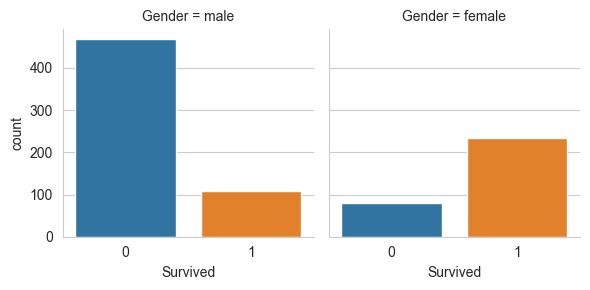

In [15]:
grid = sns.FacetGrid(titanic_data, col='Gender', col_wrap=2, hue='Survived')
grid.map(sns.countplot,'Survived',order=[0,1])

We can see that if we know the gender of the passenger, we are quite likely to know whether or not they survived. Let's see if we can express this statistically, using the χ2 test of independence. To do this, we first need to create a contingency table

In [16]:
ctable = pd.crosstab(titanic_data.Gender, titanic_data.Survived)
ctable

Survived,0,1
Gender,,
female,81,233
male,468,109


In [17]:
statistic, p, dof, exfr = stats.chi2_contingency(ctable, correction=True)
print('The chi square statistic is {:.2f}. The critical value for {} degrees of freedom at an alpha level of 0.05 is {:.2f}.'.
      format(statistic, dof, stats.chi2.ppf(0.95, 1)))


The chi square statistic is 260.72. The critical value for 1 degrees of freedom at an alpha level of 0.05 is 3.84.


As the chi-square statistic is more extreme than the critical value, i.e. it lies in the rejection region, the assumption of independence of the **Survived** and **Gender** variables can be rejected.

What about **Age**? Let's first replace the missing values with the imputed copy and then produce a conditional density plot to determine if there is any relationship between the age of a passenger and the likelihood of their survival. 

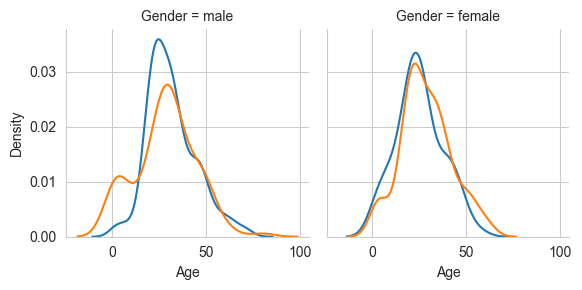

In [18]:
titanic_data['Age'] =  age_imputed_knn
grid = sns.FacetGrid(titanic_data, col='Gender', col_wrap=2, hue='Survived')
_ = grid.map(sns.kdeplot,'Age')

From these plots, it doesn't look like there is a significant difference in age distributions for those who survived and those who did not. We won't stop there, however. 

## Feature Engineering

Let's engineer a new feature indicating if the passenger was a child (Age < 18) or not and check that for co-occurence. 

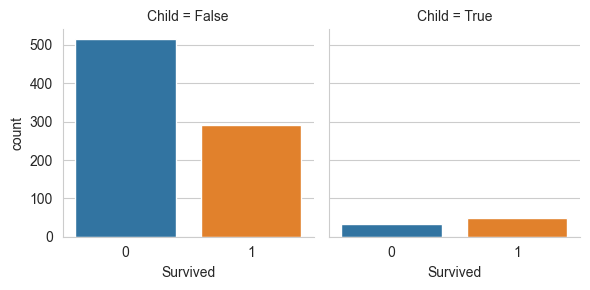

In [19]:
titanic_data['Child'] = titanic_data['Age'] < 16
grid = sns.FacetGrid(titanic_data, col='Child', col_wrap=2, hue='Survived')
_ = grid.map(sns.countplot,'Survived',order=[0,1])

In [20]:
ctable = pd.crosstab(titanic_data['Child'], titanic_data.Survived)
ctable

Survived,0,1
Child,,
False,515,292
True,34,50


In [21]:
statistic, p, dof, exfr = stats.chi2_contingency(ctable, correction=True)
print('The chi square statistic is {:.2f}. The critical value at an alpha level of 0.05 is {:.2f}.'.
      format(statistic, stats.chi2.ppf(0.95, 1)))

The chi square statistic is 16.55. The critical value at an alpha level of 0.05 is 3.84.


Once again, as the chi-square statistic is more extreme than the critical value, i.e. it lies in the rejection region, the assumption of independence of the **Survived** and **Child** variables can be rejected. However, the chi-square statistic is not quite as high as it was for the **Survived** and **Gender** variables, we can assume that the relationship between the two is not as strong.

We will now move on to examining a variable with very **high cardinality - Name**. As every value in this variable is unique, we could conclude that it would carry no information about the variable we are trying to predict, namely **Survived**. In many cases, this conclusion would be the correct one, but before adding the variable to our exclusion list, let's see if we can extract any useful information from it. In other words, we will do a little **feature engineering**. 

In [22]:
titanic_data['Title'] = titanic_data['Name']. \
  apply(lambda x: re.search(' ([A-Z][a-z]+)\.', x).group(1))

What the code above does is to use [regular expressions](https://docs.python.org/3.8/library/re.html) to search for a pattern in the name (a space, followed by one or more alphabetical characters, followed by a period) in order to extract the titles from the **Name** variable. These are then added as a new column to the dataframe. 

We will quickly examine the dataframe to see results of our work up to now.

In [23]:
titanic_data

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,False,Rev
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,False,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,20.4,1,2,W./C. 6607,23.4500,NaN,S,False,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,False,Mr


Now we can examine the unique values for **Title**. It is quite likely we are going to have to do some tidying up here! Note that this procedure will result in some information loss and is not a strategy that should be blindly followed, but instead should be carried out (or not) on a case-by-case basis.

In [24]:
titanic_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

We will first tidy up some of the more commonplace titles. 

In [25]:
titanic_data.loc[titanic_data['Title'] == 'Mlle','Title'] = 'Miss'
titanic_data.loc[titanic_data['Title'] == 'Ms','Title'] = 'Miss'
titanic_data.loc[titanic_data['Title'] == 'Mme','Title'] = 'Mrs'

Now we turn our attention to some of rarer titles in the dataset. We will group all these remaining titles together. While we are at it, we will also create a **Surname** variable.

In [26]:
common_titles = ['Mr', 'Mrs', 'Miss', 'Master']
titanic_data.loc[~titanic_data['Title'].isin(common_titles),'Title'] = 'Other'

We can then produce a contingency table examining the engineered feature **Title** and its relationship to target variable **Survived** 

In [27]:
pd.crosstab(titanic_data['Title'], titanic_data['Survived'])

Survived,0,1
Title,,
Master,17,23
Miss,55,130
Mr,436,81
Mrs,26,100
Other,15,8


This contingency table is telling us very little that we could not already identify from our examination of other variables. However, we will keep this newly-created feature just in case it carries some predictive power when combined with other variables (features). 


Let's move on to examining family size and its relationship to our target variable. Here we will use a box and whisker plot to examine the distribution of family sizes for each level of our target variable.

In [28]:
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch'] + 1
pd.crosstab(titanic_data['FamilySize'], titanic_data['Survived'])

Survived,0,1
FamilySize,,
1,374,163
2,72,89
3,43,59
4,8,21
5,12,3
6,19,3
7,8,4
8,6,0
11,7,0


Let's re-engineer the **FamilySize** feature to explore this more. 

Families of more than one and less than five are labelled 'Small'. Any family of over five is labelled 'Large'. Families of one are labelled 'Single'. From this recoding, we will produce a contingency table and will visualise it using a heatmap.

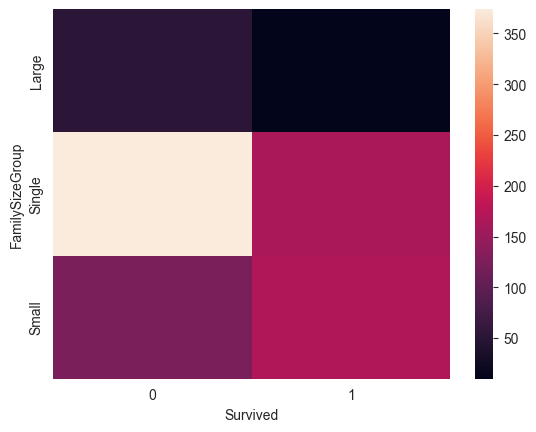

In [29]:
titanic_data.loc[titanic_data['FamilySize'] >= 5,'FamilySizeGroup'] = 'Large'
titanic_data.loc[titanic_data['FamilySize'] < 5,'FamilySizeGroup'] = 'Small'
titanic_data.loc[titanic_data['FamilySize'] == 1,'FamilySizeGroup'] = 'Single'
ctable = pd.crosstab(titanic_data['FamilySizeGroup'], titanic_data['Survived'])
_ = sns.heatmap(ctable)

The plot seems to validate the initial impression, namely that there’s a survival penalty among singles and large families, but a benefit for passengers in small families. We will keep this feature.

As you can see, we have one variable, **Fare**, which contains continuous values. Because the simplest implementation of model we will be using (Naïve Bayes) requires categorical data, we will need to bin these values. We will do this by dividing the values into four equally-sized partitions (quartiles) and we will save the cut points for the quartiles so we can apply them to the *test* data.

In [30]:
titanic_data['Fare Class'] = pd.qcut(titanic_data['Fare'], 4, labels=False)
cut_points = list([0])
cut_points.extend(titanic_data['Fare'].quantile([0.25,0.5,0.75]).values.tolist())
for index in range(len(cut_points)) : 
    titanic_data.loc[titanic_data['Fare'] > cut_points[index],'Fare Class'] = index


In [31]:
titanic_data

,PassengerId,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,Title,FamilySize,FamilySizeGroup,Fare Class
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,Mr,2,Small,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,Mrs,2,Small,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,Miss,1,Single,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,Mrs,2,Small,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,False,Mr,1,Single,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,False,Other,1,Single,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,False,Miss,1,Single,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,20.4,1,2,W./C. 6607,23.4500,NaN,S,False,Miss,4,Small,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,False,Mr,1,Single,2


In [32]:
 pd.crosstab(titanic_data['Fare Class'], titanic_data['Survived'])

Survived,0,1
Fare Class,,
0,179,44
1,156,68
2,121,101
3,93,129


## Building a predictive model

Before we start building a predictive model, we first remove some of the redundant variables

Next we need to dummy encode nominal and ordinal data.

Let's examine the dummy encoded data...

Now we build our Naïve Bayes model

Now we can use our model to predict survival on the *test* dataset.

Having produced predictions, we can produce a **Confusion Matrix** to allow us to carry out an initial evaluation of the performance of our model.

## Summary

In this tutorial we have performed exploratory data analysis on a simple dataset, handled missing values and carried out some basic feature engineering. Having prepared the data, we then built and evaluated a Naïve Bayes model using a confusion matrix.

### For you to do

Using the [Scikit learn documentation for model metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics), see if you can find out the accuracy, balanced accuracy and AUC score for the model we built.